# Check Sky Background and zero point units from visit in LSSTComCamSim

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-05-07
- last update : 2024-05-09
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
from astropy import constants as const
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = collection2
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
tract_sel = 2494
suptitle = collectionStr + f" inst = {instrument} tract = {tract_sel}"
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

### Import rubinsimphot
- usefull to check the numbers

In [5]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [6]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [7]:
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [8]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [9]:
fdir = get_data_dir()
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')   
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]

#path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')
#hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
#filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
#total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]

In [10]:
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Z","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [11]:
FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

#FILTERWL = np.array([[ 353.        ,  385.        ,  369.        ,   32.        ],
#                  [ 393.        ,  560.        ,  476.5       ,  167.        ],
#                  [ 557.        ,  703.        ,  630.        ,  146.        ],
#                  [ 688.        ,  859.        ,  773.5       ,  171.        ],
#                  [ 812.        ,  938.        ,  875.76271186,  126.        ],
#                  [ 934.        , 1060.        ,  997.        ,  126.        ]])

F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
Aeff  = np.pi*642.3**2/4 # cm2  Reff=6.423 m

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*Aeff*DT/gel/hP)

In [12]:
import sys
sys.path.append('../lib')

In [13]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


### Import atmospheric emulator

In [14]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [15]:
from getObsAtmo import ObsAtmo
emul_atm = ObsAtmo()

LSST site name validated as LSST observatory


In [16]:
WL = emul_atm.GetWL()

### Additional functions

In [17]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [18]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [19]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [20]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [21]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


In [22]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [23]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [24]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [25]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[2494, 2495, 2661, 2662, 3200, 3345, 3346, 3384, 3385, 3533, 3534, 6914, 6915, 7148, 7149, 7445, 7446, 7683, 7684, 9570, 9637, 9638, 9812, 9813, 9880, 9881]


In [26]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [27]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [28]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
730865860864    20240403
730865860865    20240403
730865860866    20240403
730865860867    20240403
730865860868    20240403
                  ...   
730866060292    20240403
730866060293    20240403
730866060294    20240403
730866060295    20240403
730866060296    20240403
Name: nightObs, Length: 6301, dtype: int64

In [29]:
#  get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [30]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [31]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [32]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID","zeroPoint","airmass","skyBg","skyNoise","expTime"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_table_saved.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv found !!! ==> Read it !!!


In [33]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [34]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.471790,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.011240,-15.026212,0,0.711160,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,0,0,20240403,2024-04-03 23:30:14.555496,1.050426,6914,246
730865860865,7024040300001,r_03,r,124.745824,-14.826505,18.059967,31.238535,1.508598,1674.763306,32.659889,0.004810,0.002649,521,-0.000758,0.000405,0.010847,0.010906,-0.000540,0.010071,0.006677,0.011858,327.926941,11.528691,1.124846,0.350736,0.974059,-14.826505,1,0.710764,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,1,0,20240403,2024-04-03 23:30:14.555496,1.051820,7149,12
730865860866,7024040300001,r_03,r,124.873418,-14.626731,18.294695,31.259706,1.525470,1709.555664,33.396534,0.004649,0.002711,499,-0.000471,-0.000007,0.010723,0.010910,0.000434,0.009015,0.005919,0.015276,507.804199,11.484890,1.100101,0.343598,1.012796,-14.626731,2,0.718461,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,2,0,20240403,2024-04-03 23:30:14.555496,1.053236,7149,61
730865860867,7024040300001,r_03,r,124.824851,-15.149693,17.819584,31.267454,1.514115,1717.083984,34.223988,0.004732,0.002868,504,-0.000470,-0.000685,0.009737,0.010434,-0.000375,0.010328,0.006824,0.019305,371.574188,11.773538,1.116663,0.342092,1.027357,-15.149693,3,0.713278,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,3,0,20240403,2024-04-03 23:30:14.555496,1.050393,6914,227
730865860868,7024040300001,r_03,r,124.952564,-14.949870,18.054384,31.265049,1.510671,1714.527710,33.346077,0.004954,0.002795,472,0.000277,0.000023,0.009188,0.009661,0.000165,0.010904,0.007214,0.009335,364.833038,11.792562,1.121760,0.342602,1.022816,-14.949870,4,0.711782,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,4,0,20240403,2024-04-03 23:30:14.555496,1.051787,6914,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r_03,r,299.857944,-40.858541,19.874241,31.276102,1.663994,1544.489258,31.839106,0.006128,0.003535,742,0.000638,-0.000605,0.012558,0.010842,-0.000502,0.011414,0.006865,0.012346,238.200607,11.011467,0.924563,0.380320,1.043851,-40.858541,4,0.784160,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199510,60404.435870,33.0575,4071,3999,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,2

## Configuration

In [35]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Instrument throughput')

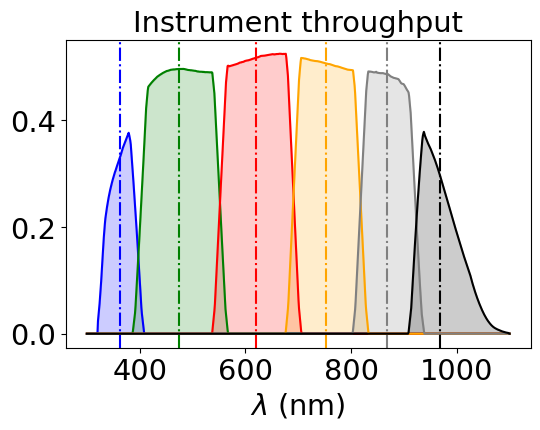

In [36]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")

Text(0.5, 1.0, 'Standard atmosphere transmission')

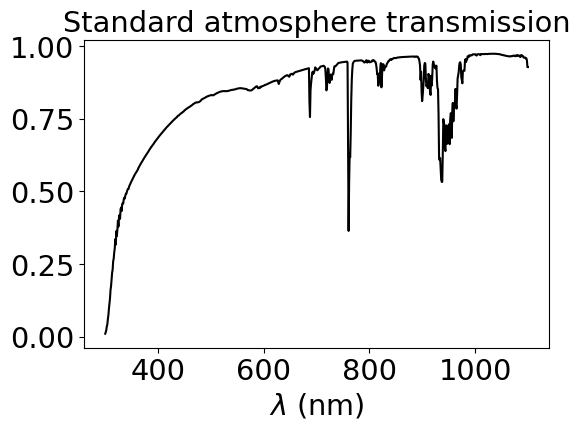

In [37]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Text(0.5, 1.0, 'Total filter throughput')

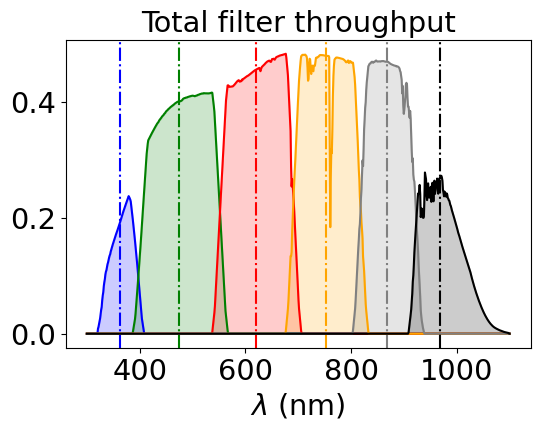

In [38]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput")

## Zero-Point

https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/bandpass.py

In [39]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
  
    zp = pc.bandpass_total_std[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

,u,g,r,i,z,y
ZP (mag),30.05,31.46,31.26,30.97,30.58,29.78


## Calculation on Dark Sky

In [40]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [41]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [42]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

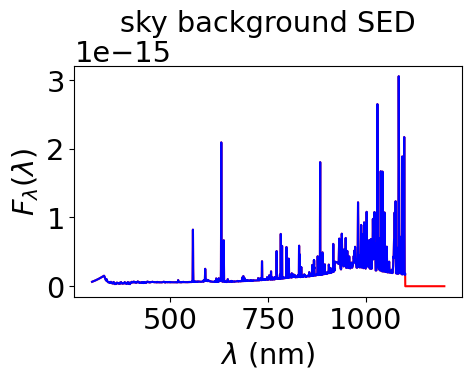

In [43]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [44]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_mags[f] = darksky.calc_mag(pc.bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark sky magnitudes/as']).round(2)

,u,g,r,i,z,y
Dark sky magnitudes/as,22.96,22.26,21.21,20.5,19.57,18.61


### Check the instrument

#### Photometric parameters

In [45]:
np.pi * (6.423 / 2.0 * 100) ** 2

324015.4546769212

In [46]:
A

324015.4546769212

In [47]:
# Calculate the standard dark sky zenith magnitudes - for reference
#photoparams = set_photometric_parameters(30, 1 , readnoise=None)
#photoparams._gain = 1
#photoparams._exptime = 1.
#photoparams._effarea = Aeff

In [48]:
#surface : in cm2
# exposure time : in sec
# gain : electrons per ADU
# Cb = C \int Fnu S dwl/wl
# C = (pi*D^2/(4gh))* Dt = S/(gh)* Dt

photoparams._exptime = 1.

from pprint import pprint
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 324015.4546769212,
 '_exptime': 1.0,
 '_gain': 1.693343125,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.2,
 '_readnoise': 12.3936875,
 '_sigma_sys': 0.005}


https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [49]:
# Calculate the standard dark sky zenith magnitudes - for reference

darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/s']).round(2)

,u,g,r,i,z,y
Dark sky adu/s,39.85,202.1,399.68,568.19,899.78,1165.66


In [50]:
# Calculate the standard dark sky zenith magnitudes - for reference
photoparams = set_photometric_parameters(30, 1 , readnoise=None)


photoparams._exptime = 30.



darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/expo']).round(2)

,u,g,r,i,z,y
Dark sky adu/expo,880.09,4463.72,8827.78,12549.69,19873.49,25746.04


## Sky Background

In [51]:
ccd_visit_table_g = ccd_visit_table[ccd_visit_table["band"] == 'g']
ccd_visit_table_r = ccd_visit_table[ccd_visit_table["band"] == 'r']
ccd_visit_table_i = ccd_visit_table[ccd_visit_table["band"] == 'i']

In [52]:
ccd_visit_table_g

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865866240,7024040300022,g_01,g,124.784571,-15.265897,15.979365,31.354979,2.451715,322.351501,19.016087,0.008969,0.005492,373,0.000192,0.000062,0.010216,0.011057,0.002104,0.016086,0.006546,0.019297,472.769379,12.419865,0.492172,0.869237,0.967699,-15.265897,0,1.155846,69.773608,2024-04-03 23:46:55.824000,60403.990924,30.0,2024-04-03 23:46:40.824000,60403.99075,33.0544,4071,3999,124.716201,-15.410191,124.636268,-15.197361,124.852856,-15.121567,124.932977,-15.334329,5376,21,20240403,2024-04-03 23:46:40.824000,1.040192,6914,210
730865866242,7024040300022,g_01,g,124.618851,-14.824225,16.342335,31.363281,2.460139,325.820312,17.244532,0.008998,0.005345,342,-0.000049,-0.000173,0.011314,0.011765,0.001220,0.015511,0.006304,0.022413,444.283813,12.391698,0.488807,0.859983,0.982611,-14.824225,2,1.159396,69.773608,2024-04-03 23:46:55.824000,60403.990924,30.0,2024-04-03 23:46:40.824000,60403.99075,33.0544,4071,3999,124.550507,-14.968487,124.470924,-14.755597,124.687108,-14.679939,124.766893,-14.892767,5378,21,20240403,2024-04-03 23:46:40.824000,1.042103,7149,13
730865866243,7024040300022,g_01,g,125.013368,-15.185681,16.131117,31.360659,2.459129,324.413116,18.322250,0.009823,0.005857,358,-0.000454,0.000333,0.011112,0.011135,0.002865,0.018014,0.007320,0.015012,519.376831,12.395638,0.489209,0.863714,0.977876,-15.185681,3,1.158236,69.773608,2024-04-03 23:46:55.824000,60403.990924,30.0,2024-04-03 23:46:40.824000,60403.99075,33.0544,4071,3999,124.945168,-15.330054,124.865038,-15.117298,125.081478,-15.041274,125.161789,-15.253958,5379,21,20240403,2024-04-03 23:46:40.824000,1.040985,6914,225
730865866244,7024040300022,g_01,g,124.930215,-14.964937,16.310301,31.369553,2.457011,327.588776,16.883184,0.008356,0.004796,352,0.000525,0.000235,0.010801,0.010670,0.001557,0.020148,0.008188,0.009127,422.055725,12.499806,0.490053,0.855341,0.994032,-14.964937,4,1.158020,69.773608,2024-04-03 23:46:55.824000,60403.990924,30.0,2024-04-03 23:46:40.824000,60403.99075,33.0544,4071,3999,124.862028,-15.109300,124.782062,-14.896497,124.998308,-14.820553,125.078462,-15.033282,5380,21,20240403,2024-04-03 23:46:40.824000,1.041933,6914,260
730865866245,7024040300022,g_01,g,124.847236,-14.744165,16.490845,31.364349,2.459225,325.299225,18.130884,0.008886,0.005215,369,-0.000329,-0.001092,0.009125,0.010298,0.001067,0.016404,0.006671,0.010720,435.910431,12.445275,0.489171,0.861361,0.984550,-14.744165,5,1.159841,69.773608,2024-04-03 23:46:55.824000,60403.990924,30.0,2024-04-03 23:46:40.824000,60403.99075,33.0544,4071,3999,124.779063,-14.888502,124.699266,-14.675677,124.915316,-14.599816,124.995302,-14.812559,5381,21,20240403,2024-04-03 23:46:40.824000,1.042900,7149,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866055172,7024040300760,g_01,g,300.133713,-40.949909,22.860332,31.403135,1.548339,670.345886,21.987268,0.008794,0.005100,686,0.000524,0.000231,0.011758,0.011172,0.001673,0.012895,0.008322,0.008108,302.408722,16.363680,1.234028,0.417993,1.057464,-40.949909,4,0.729877,212.787604,2024-04-04 10:12:08.987506,60404.425104,30.0,2024-04-04 10:11:53.987506,60404.42493,33.0541,4071,3999,300.087227,-40.795155,300.339304,-40.917303,300.180415,-41.104643,299

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

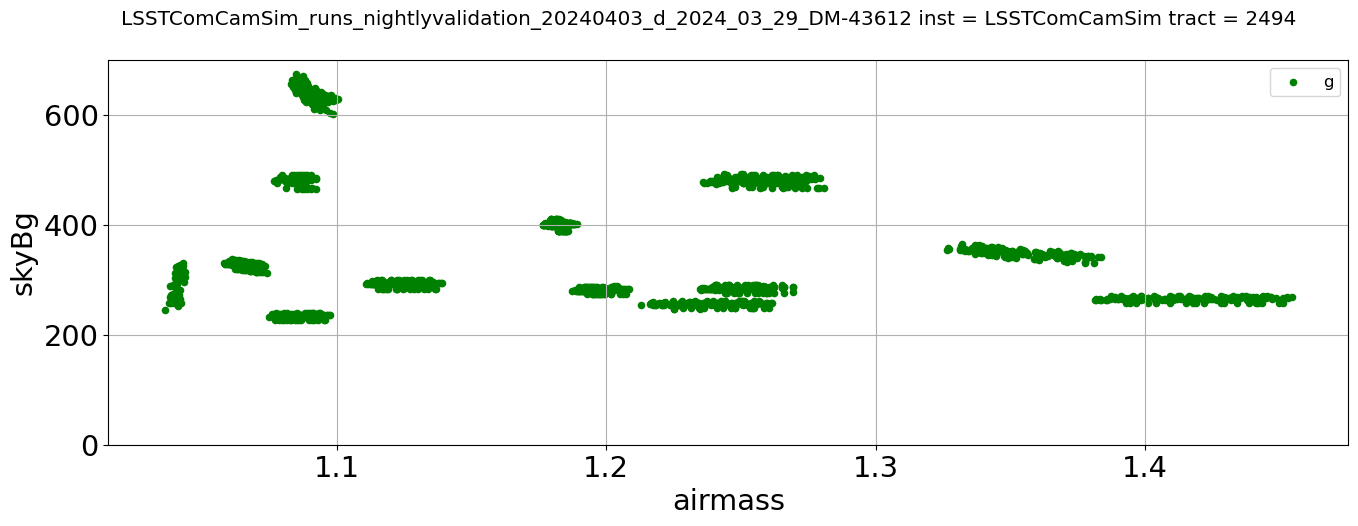

In [53]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=True)
ccd_visit_table_g.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="g",grid=True,label="g")
ax.set_ylim(0.,700)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

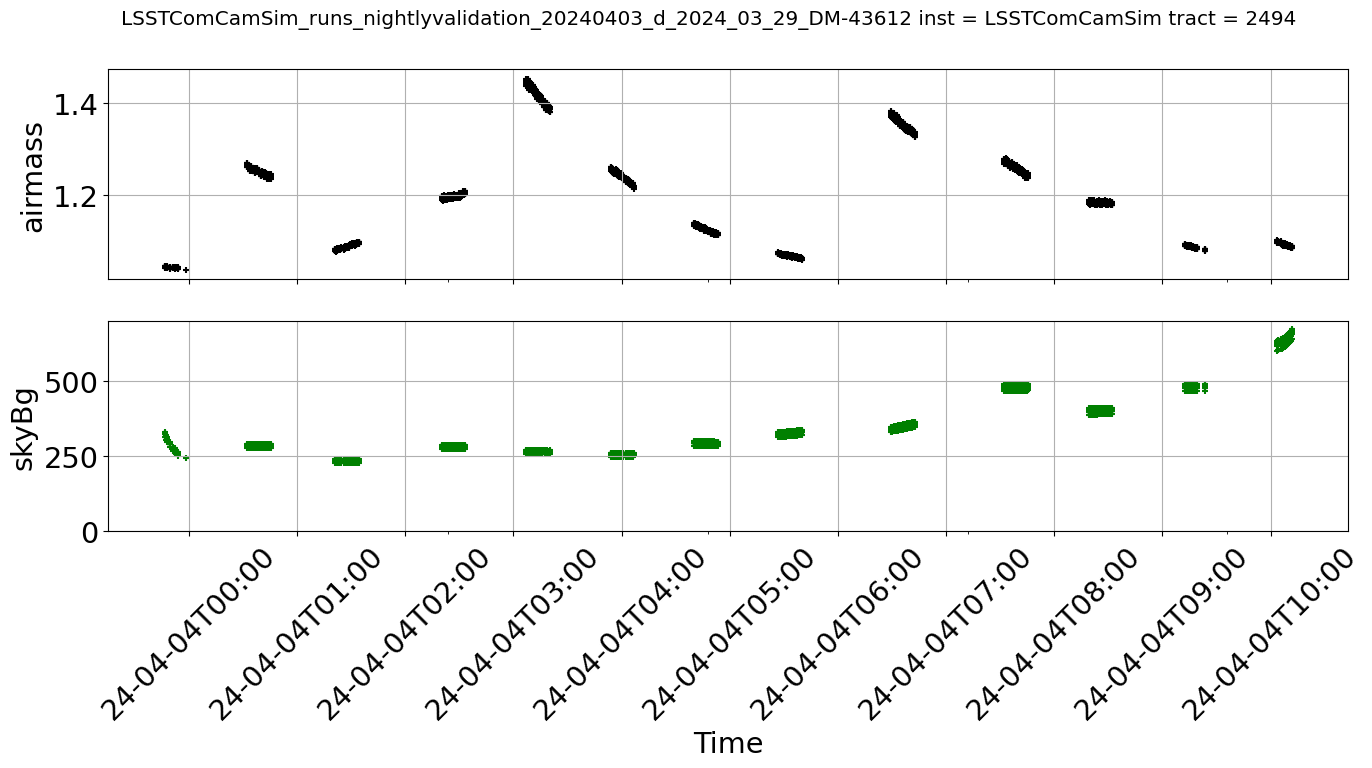

In [54]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,6),sharex=True)
ccd_visit_table_g.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_g.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="g",rot=45)
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,700)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

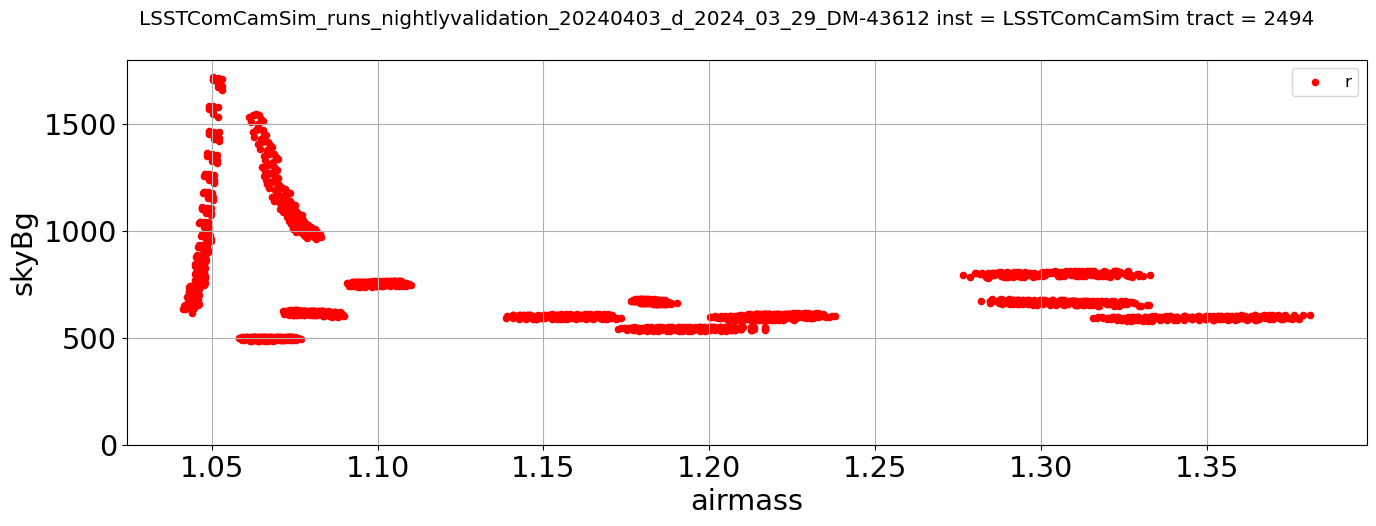

In [55]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=True)
ccd_visit_table_r.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="r",grid=True,label="r")
ax.set_ylim(0.,1800)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

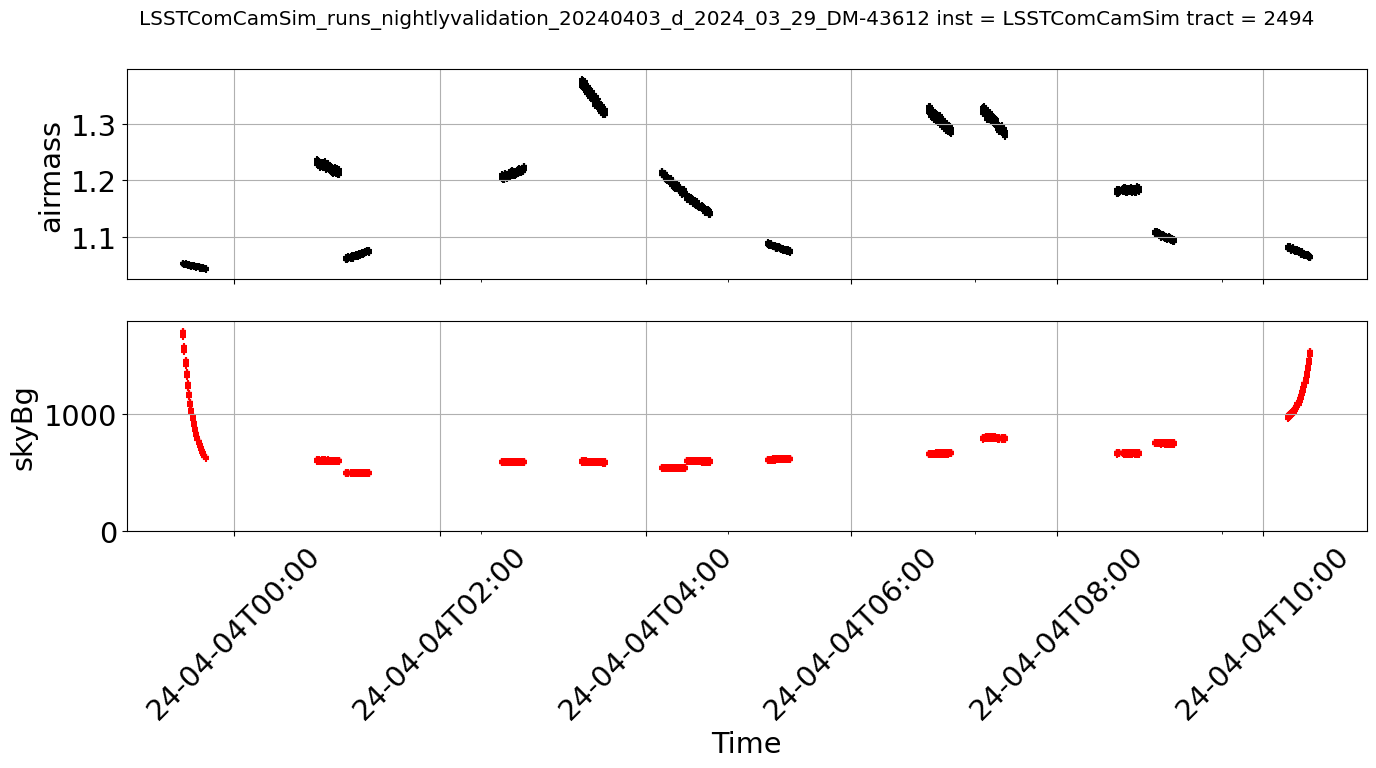

In [56]:
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,6),sharex=True)
ccd_visit_table_r.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_r.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="r",rot=45)
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,1800)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

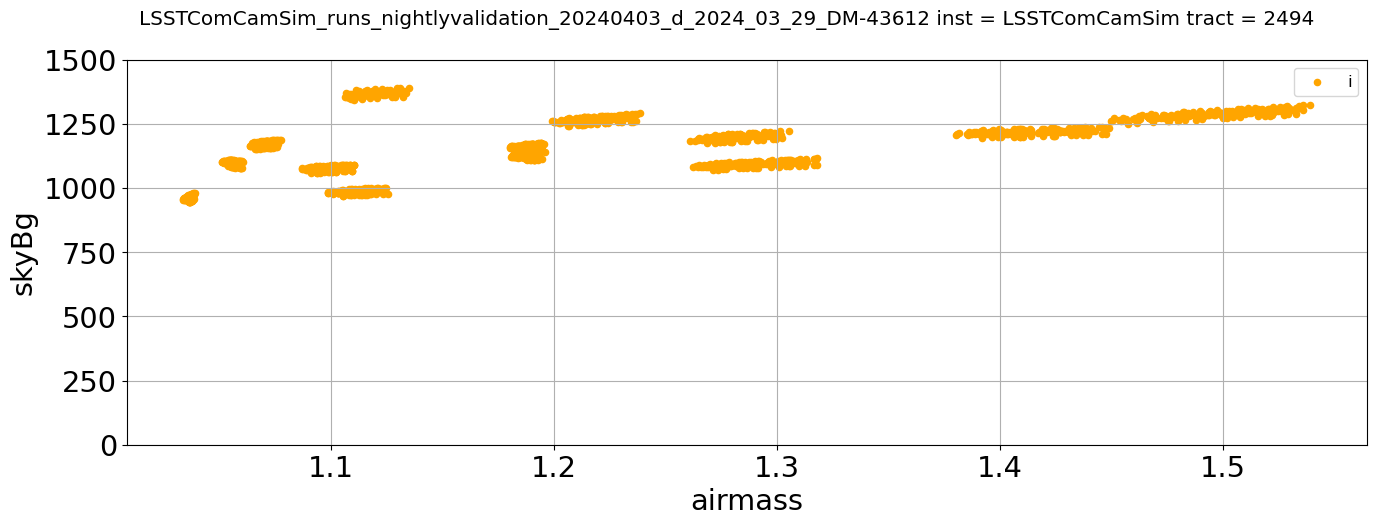

In [57]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=True)
ccd_visit_table_i.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="orange",grid=True,label="i")
ax.set_ylim(0.,1500)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612 inst = LSSTComCamSim tract = 2494')

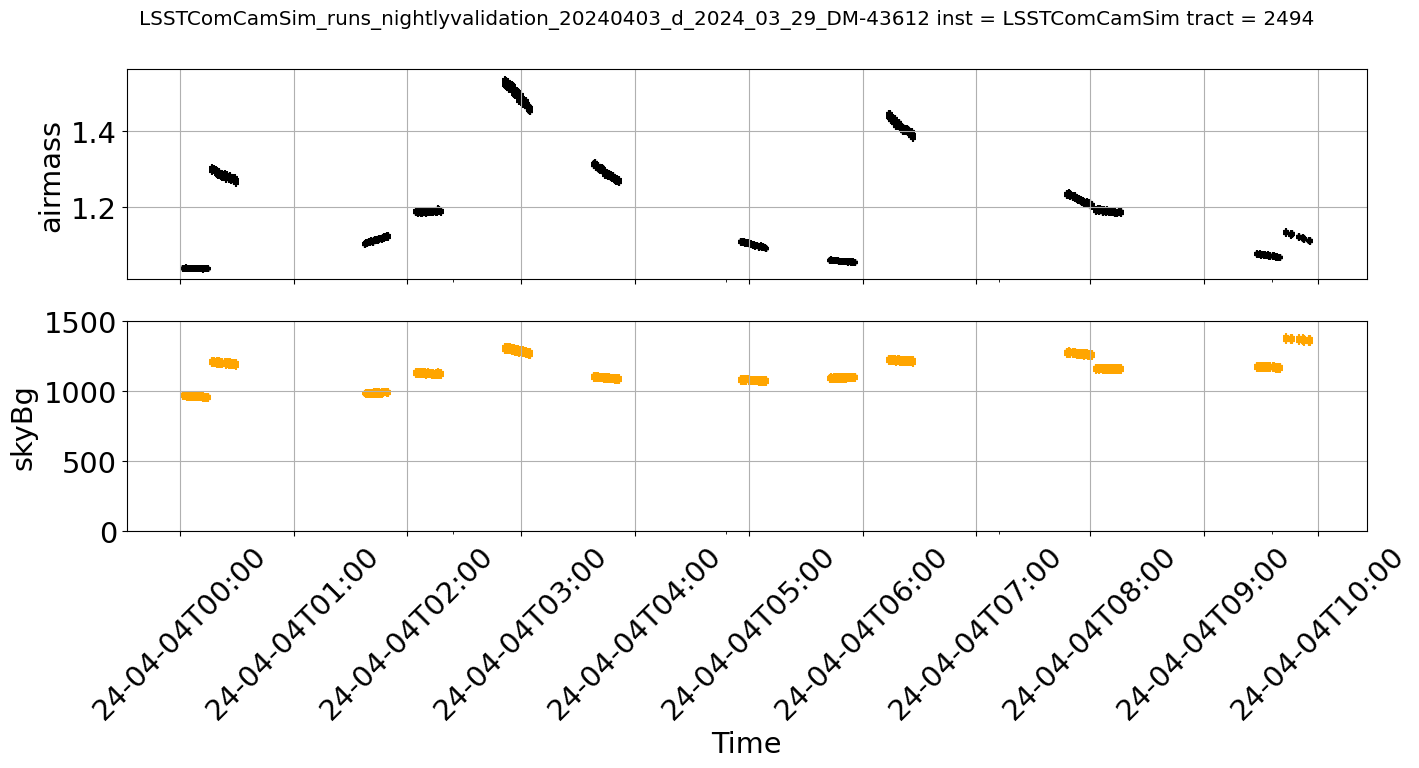

In [58]:
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,6),sharex=True)
ccd_visit_table_i.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_i.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="orange",rot=45)
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,1500)
plt.suptitle(suptitle)